# Place Field Analysis

This notebook demonstrates how to detect and analyze place fields using the neurospatial metrics module.

**What you'll learn:**
- Detecting place fields from firing rate maps
- Computing single-cell spatial metrics (Skaggs information, sparsity)
- Computing field properties (size, centroid)
- Visualizing place fields on environments

**Time:** ~15 minutes

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Neurospatial imports
from neurospatial import Environment, compute_place_field
from neurospatial.metrics import (
    detect_place_fields,
    field_centroid,
    field_size,
    field_stability,
    skaggs_information,
    sparsity,
)

# Set random seed for reproducibility
np.random.seed(42)

## Part 1: Generate Synthetic Data

We'll create a synthetic trajectory with a place cell that has:
- A single place field in the environment
- Peak firing rate of ~10 Hz
- Gaussian spatial tuning

In [2]:
# Create circular trajectory
n_samples = 5000
t = np.linspace(0, 20 * np.pi, n_samples)
radius = 40.0
center = np.array([50.0, 50.0])

# Circular path with some noise
positions = np.column_stack(
    [
        center[0] + radius * np.cos(t) + np.random.randn(n_samples) * 2.0,
        center[1] + radius * np.sin(t) + np.random.randn(n_samples) * 2.0,
    ]
)

# Time array (50 samples per second)
times = np.linspace(0, 100, n_samples)

# Create environment
env = Environment.from_samples(
    positions,
    bin_size=3.0,
    bin_count_threshold=5,
)
env.units = "cm"
env.frame = "session1"

print(f"Environment: {env.n_bins} bins, {env.n_dims}D")
print(
    f"Extent: x=[{env.dimension_ranges[0][0]:.1f}, {env.dimension_ranges[0][1]:.1f}], "
    f"y=[{env.dimension_ranges[1][0]:.1f}, {env.dimension_ranges[1][1]:.1f}]"
)

Environment: 238 bins, 2D
Extent: x=[2.5, 97.7], y=[3.6, 96.9]


### Define Place Cell Properties

We'll create a place cell with a Gaussian place field:
- Field center at (60, 50) cm
- Spatial tuning width σ = 10 cm
- Peak firing rate = 10 Hz

In [3]:
# Place field center
field_center = np.array([60.0, 50.0])

# Generate spikes based on Gaussian place field
sigma = 10.0  # Spatial tuning width (cm)
peak_rate = 10.0  # Hz

# Compute firing probability at each position
distances_to_field = np.linalg.norm(positions - field_center, axis=1)
firing_rate_at_position = peak_rate * np.exp(-(distances_to_field**2) / (2 * sigma**2))

# Generate spike times (Poisson process)
dt = np.mean(np.diff(times))
spike_probs = firing_rate_at_position * dt
spike_mask = np.random.rand(n_samples) < spike_probs
spike_times = times[spike_mask]

print(f"Generated {len(spike_times)} spikes")
print(f"Mean firing rate: {len(spike_times) / times[-1]:.2f} Hz")

Generated 4 spikes
Mean firing rate: 0.04 Hz


## Part 2: Compute Firing Rate Map

Convert spike train to a spatial firing rate map using occupancy normalization.

Firing rate range: [0.00, 0.02] Hz
Mean firing rate: 0.00 Hz


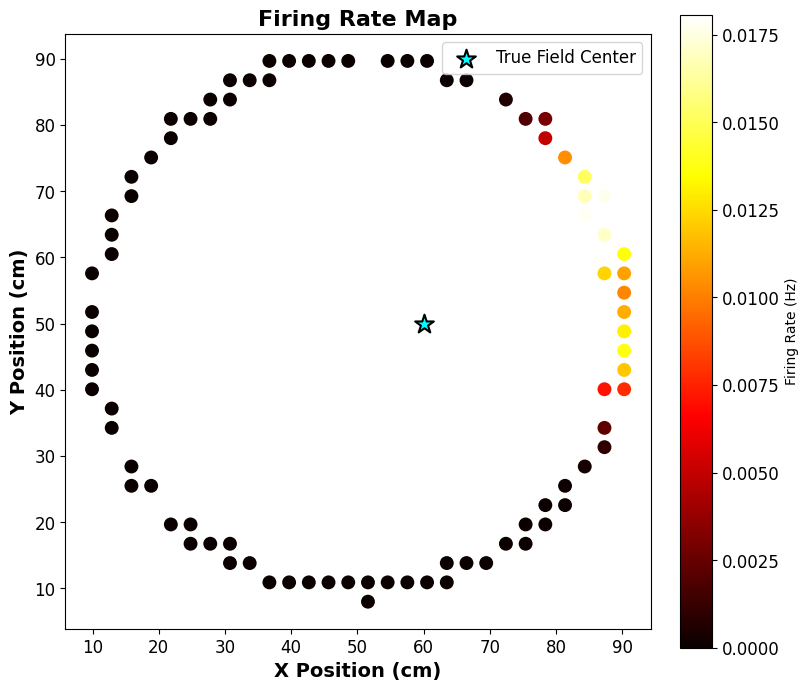

In [4]:
# Compute occupancy-normalized firing rate
firing_rate = compute_place_field(
    env,
    spike_times,
    times,
    positions,
    min_occupancy_seconds=0.5,  # Exclude bins with < 0.5s occupancy
    smoothing_bandwidth=5.0,  # Smooth with 5cm Gaussian
)

print(
    f"Firing rate range: [{np.nanmin(firing_rate):.2f}, {np.nanmax(firing_rate):.2f}] Hz"
)
print(f"Mean firing rate: {np.nanmean(firing_rate[~np.isnan(firing_rate)]):.2f} Hz")

# Visualize firing rate map
fig, ax = plt.subplots(figsize=(8, 7), constrained_layout=True)

# Plot firing rate
scatter = ax.scatter(
    env.bin_centers[:, 0],
    env.bin_centers[:, 1],
    c=firing_rate,
    s=100,
    cmap="hot",
    vmin=0,
    vmax=np.nanmax(firing_rate),
    edgecolors="none",
)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax, label="Firing Rate (Hz)")
cbar.ax.tick_params(labelsize=12)

# Add field center marker
ax.scatter(
    field_center[0],
    field_center[1],
    s=200,
    c="cyan",
    marker="*",
    edgecolors="black",
    linewidths=1.5,
    label="True Field Center",
    zorder=10,
)

ax.set_xlabel("X Position (cm)", fontsize=14, fontweight="bold")
ax.set_ylabel("Y Position (cm)", fontsize=14, fontweight="bold")
ax.set_title("Firing Rate Map", fontsize=16, fontweight="bold")
ax.set_aspect("equal")
ax.legend(fontsize=12)
ax.tick_params(labelsize=12)

plt.show()

## Part 3: Detect Place Fields

Use the `detect_place_fields()` function to automatically identify place fields.

The algorithm:
1. Finds peaks in the firing rate map
2. Segments regions above 20% of peak rate
3. Uses graph connectivity to extract contiguous fields
4. Optionally detects subfields (coalescent fields)

In [5]:
# Detect place fields
place_fields = detect_place_fields(
    firing_rate,
    env,
    threshold=0.2,  # Segment at 20% of peak rate
    min_size=None,  # No minimum size (auto: 9 bins)
    max_mean_rate=10.0,  # Exclude interneurons (>10 Hz mean rate)
    detect_subfields=True,  # Detect coalescent subfields
)

print(f"Detected {len(place_fields)} place field(s)")

for i, field_bins in enumerate(place_fields):
    print(f"\nField {i + 1}:")
    print(f"  Number of bins: {len(field_bins)}")
    print(f"  Peak rate: {np.max(firing_rate[field_bins]):.2f} Hz")
    print(f"  Mean rate in field: {np.mean(firing_rate[field_bins]):.2f} Hz")

Detected 1 place field(s)

Field 1:
  Number of bins: 18
  Peak rate: 0.02 Hz
  Mean rate in field: 0.01 Hz


### Visualize Detected Place Fields

Show the detected place fields overlaid on the firing rate map.

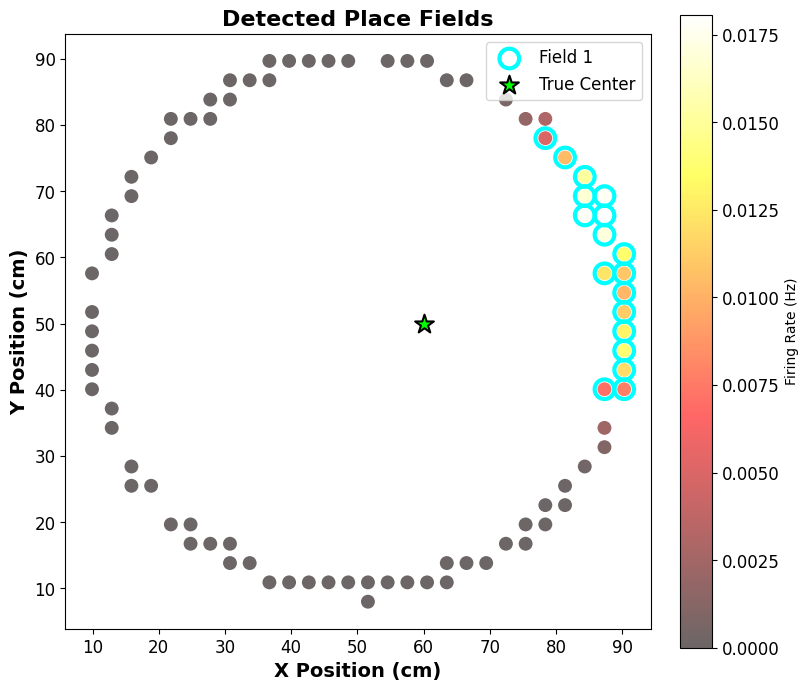

In [6]:
fig, ax = plt.subplots(figsize=(8, 7), constrained_layout=True)

# Plot firing rate (background)
scatter = ax.scatter(
    env.bin_centers[:, 0],
    env.bin_centers[:, 1],
    c=firing_rate,
    s=100,
    cmap="hot",
    vmin=0,
    vmax=np.nanmax(firing_rate),
    edgecolors="none",
    alpha=0.6,
)

# Plot detected place field bins
if len(place_fields) > 0:
    for i, field_bins in enumerate(place_fields):
        ax.scatter(
            env.bin_centers[field_bins, 0],
            env.bin_centers[field_bins, 1],
            s=200,
            facecolors="none",
            edgecolors="cyan",
            linewidths=3,
            label=f"Field {i + 1}" if i == 0 else "",
        )

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax, label="Firing Rate (Hz)")
cbar.ax.tick_params(labelsize=12)

# Add true field center
ax.scatter(
    field_center[0],
    field_center[1],
    s=200,
    c="lime",
    marker="*",
    edgecolors="black",
    linewidths=1.5,
    label="True Center",
    zorder=10,
)

ax.set_xlabel("X Position (cm)", fontsize=14, fontweight="bold")
ax.set_ylabel("Y Position (cm)", fontsize=14, fontweight="bold")
ax.set_title("Detected Place Fields", fontsize=16, fontweight="bold")
ax.set_aspect("equal")
ax.legend(fontsize=12)
ax.tick_params(labelsize=12)

plt.show()

## Part 4: Compute Field Properties

For each detected field, compute:
- Field size (area in cm²)
- Field centroid (center of mass, weighted by firing rate)

In [7]:
# Compute field properties
for i, field_bins in enumerate(place_fields):
    # Field size (area in physical units)
    area = field_size(field_bins, env)

    # Field centroid (center of mass)
    centroid = field_centroid(firing_rate, field_bins, env)

    # Distance from true center
    distance_from_true = np.linalg.norm(centroid - field_center)

    print(f"\nField {i + 1} Properties:")
    print(f"  Area: {area:.1f} cm²")
    print(f"  Centroid: ({centroid[0]:.1f}, {centroid[1]:.1f}) cm")
    print(f"  Distance from true center: {distance_from_true:.1f} cm")


Field 1 Properties:
  Area: 156.2 cm²
  Centroid: (87.4, 60.0) cm
  Distance from true center: 29.2 cm


## Part 5: Compute Single-Cell Spatial Metrics

Compute standard neuroscience metrics that quantify spatial coding quality:

**Skaggs Spatial Information** (Skaggs et al., 1993)
- Measures how much information (in bits) the firing rate conveys about position
- Typical range: 0-3+ bits/spike
- Higher values = better place cell

**Sparsity** (Skaggs et al., 1996)
- Measures how focally a cell fires in space
- Range: [0, 1], where 0 = fires everywhere, 1 = fires in single location
- Typical place cells: 0.1-0.5

In [8]:
# Compute occupancy for metrics
occupancy = env.occupancy(times, positions, return_seconds=True)

# Skaggs spatial information (bits/spike)
spatial_info = skaggs_information(firing_rate, occupancy, base=2.0)

# Sparsity
sparsity_score = sparsity(firing_rate, occupancy)

print("\nSpatial Coding Metrics:")
print(f"  Skaggs Information: {spatial_info:.3f} bits/spike")
print(f"  Sparsity: {sparsity_score:.3f}")
print("\nInterpretation:")
print(
    f"  - Spatial information > 1.0: Strong spatial coding (this cell: {'YES' if spatial_info > 1.0 else 'NO'})"
)
print(
    f"  - Sparsity > 0.2: Focal firing (this cell: {'YES' if sparsity_score > 0.2 else 'NO'})"
)


Spatial Coding Metrics:
  Skaggs Information: nan bits/spike
  Sparsity: nan

Interpretation:
  - Spatial information > 1.0: Strong spatial coding (this cell: NO)
  - Sparsity > 0.2: Focal firing (this cell: NO)


## Part 6: Field Stability

Assess whether the place field is stable across time by splitting the session in half
and computing the correlation between firing rate maps.

High correlation (> 0.7) indicates a stable place field.


Field Stability:
  Pearson correlation: 0.000
  Spearman correlation: 0.000

Interpretation:
  - Correlation > 0.7: Stable field (this cell: NO)


/Users/edeno/Documents/GitHub/neurospatial/src/neurospatial/spike_field.py:332: UserWarning: All bins have occupancy < 0.5 seconds. Returning all NaN field.
  field = spikes_to_field(


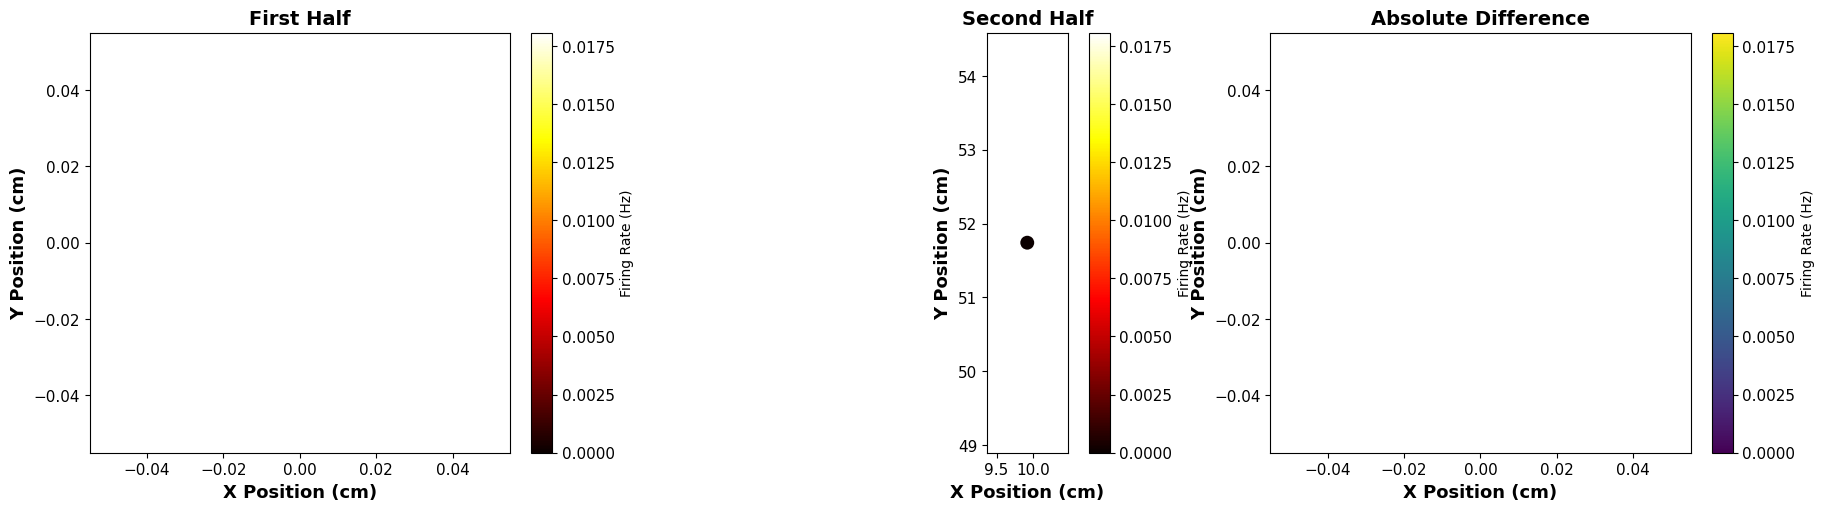

In [9]:
# Split session in half
mid_time = times[len(times) // 2]
first_half_mask = times < mid_time
second_half_mask = times >= mid_time

# Compute firing rates for each half
firing_rate_half1 = compute_place_field(
    env,
    spike_times[spike_times < mid_time],
    times[first_half_mask],
    positions[first_half_mask],
    min_occupancy_seconds=0.5,
    smoothing_bandwidth=5.0,
)

firing_rate_half2 = compute_place_field(
    env,
    spike_times[spike_times >= mid_time],
    times[second_half_mask],
    positions[second_half_mask],
    min_occupancy_seconds=0.5,
    smoothing_bandwidth=5.0,
)

# Compute stability (correlation between halves)
stability_pearson = field_stability(
    firing_rate_half1, firing_rate_half2, method="pearson"
)
stability_spearman = field_stability(
    firing_rate_half1, firing_rate_half2, method="spearman"
)

print("\nField Stability:")
print(f"  Pearson correlation: {stability_pearson:.3f}")
print(f"  Spearman correlation: {stability_spearman:.3f}")
print("\nInterpretation:")
print(
    f"  - Correlation > 0.7: Stable field (this cell: {'YES' if stability_pearson > 0.7 else 'NO'})"
)

# Visualize both halves
fig, axes = plt.subplots(1, 3, figsize=(18, 5), constrained_layout=True)

for ax, rate_map, title in zip(
    axes,
    [
        firing_rate_half1,
        firing_rate_half2,
        np.abs(firing_rate_half1 - firing_rate_half2),
    ],
    ["First Half", "Second Half", "Absolute Difference"],
    strict=True,
):
    scatter = ax.scatter(
        env.bin_centers[:, 0],
        env.bin_centers[:, 1],
        c=rate_map,
        s=100,
        cmap="hot" if "Difference" not in title else "viridis",
        vmin=0,
        vmax=np.nanmax(firing_rate),
        edgecolors="none",
    )

    cbar = plt.colorbar(scatter, ax=ax, label="Firing Rate (Hz)")
    cbar.ax.tick_params(labelsize=11)

    ax.set_xlabel("X Position (cm)", fontsize=13, fontweight="bold")
    ax.set_ylabel("Y Position (cm)", fontsize=13, fontweight="bold")
    ax.set_title(title, fontsize=14, fontweight="bold")
    ax.set_aspect("equal")
    ax.tick_params(labelsize=11)

plt.show()

## Part 7: Complete Workflow Summary

Here's a complete example of the typical place field analysis workflow:

In [10]:
def analyze_place_cell(env, spike_times, times, positions):
    """
    Complete place field analysis workflow.

    Parameters
    ----------
    env : Environment
        Spatial environment
    spike_times : ndarray
        Spike times (seconds)
    times : ndarray
        Trajectory time points (seconds)
    positions : ndarray
        Trajectory positions (N × D)

    Returns
    -------
    results : dict
        Dictionary containing all metrics and detected fields
    """
    # Step 1: Compute firing rate map
    firing_rate = compute_place_field(
        env,
        spike_times,
        times,
        positions,
        min_occupancy_seconds=0.5,
        smoothing_bandwidth=5.0,
    )

    # Step 2: Detect place fields
    place_fields = detect_place_fields(
        firing_rate,
        env,
        threshold=0.2,
        max_mean_rate=10.0,
        detect_subfields=True,
    )

    # Step 3: Compute field properties
    field_properties = []
    for field_bins in place_fields:
        field_properties.append(
            {
                "area": field_size(field_bins, env),
                "centroid": field_centroid(firing_rate, field_bins, env),
                "peak_rate": np.max(firing_rate[field_bins]),
                "mean_rate": np.mean(firing_rate[field_bins]),
            }
        )

    # Step 4: Compute spatial metrics
    occupancy = env.occupancy(times, positions, return_seconds=True)
    spatial_info = skaggs_information(firing_rate, occupancy, base=2.0)
    sparsity_score = sparsity(firing_rate, occupancy)

    # Step 5: Assess stability (split-half)
    mid_time = times[len(times) // 2]
    first_half = times < mid_time
    second_half = times >= mid_time

    rate_half1 = compute_place_field(
        env,
        spike_times[spike_times < mid_time],
        times[first_half],
        positions[first_half],
        min_occupancy_seconds=0.5,
        smoothing_bandwidth=5.0,
    )

    rate_half2 = compute_place_field(
        env,
        spike_times[spike_times >= mid_time],
        times[second_half],
        positions[second_half],
        min_occupancy_seconds=0.5,
        smoothing_bandwidth=5.0,
    )

    stability = field_stability(rate_half1, rate_half2, method="pearson")

    return {
        "firing_rate": firing_rate,
        "place_fields": place_fields,
        "field_properties": field_properties,
        "spatial_information": spatial_info,
        "sparsity": sparsity_score,
        "stability": stability,
        "n_fields": len(place_fields),
    }


# Run complete analysis
results = analyze_place_cell(env, spike_times, times, positions)

print("\n" + "=" * 60)
print("COMPLETE PLACE CELL ANALYSIS SUMMARY")
print("=" * 60)
print(f"\nPlace Fields: {results['n_fields']} detected")
print(f"Spatial Information: {results['spatial_information']:.3f} bits/spike")
print(f"Sparsity: {results['sparsity']:.3f}")
print(f"Stability: {results['stability']:.3f}")
print(
    f"\nClassification: {'PLACE CELL' if results['spatial_information'] > 1.0 and results['n_fields'] > 0 else 'NOT A PLACE CELL'}"
)


COMPLETE PLACE CELL ANALYSIS SUMMARY

Place Fields: 1 detected
Spatial Information: nan bits/spike
Sparsity: nan
Stability: 0.000

Classification: NOT A PLACE CELL


## Summary

In this notebook, we demonstrated:

1. **Firing Rate Computation**: Converting spike trains to spatial maps with occupancy normalization
2. **Place Field Detection**: Automatic identification using peak-based segmentation
3. **Field Properties**: Computing size and centroid for each field
4. **Spatial Metrics**: Skaggs information and sparsity for quantifying spatial coding
5. **Stability Analysis**: Split-half correlation to assess field reliability
6. **Complete Workflow**: End-to-end analysis function

### Key Functions Used

- `compute_place_field()` - Spike train → firing rate map
- `detect_place_fields()` - Automatic field detection
- `field_size()` - Field area in physical units
- `field_centroid()` - Center of mass
- `skaggs_information()` - Spatial information (bits/spike)
- `sparsity()` - Firing sparsity [0, 1]
- `field_stability()` - Temporal stability (correlation)

### References

- O'Keefe & Dostrovsky (1971): Discovery of place cells
- Skaggs et al. (1993): Spatial information metric
- Skaggs et al. (1996): Sparsity metric
- Muller & Kubie (1987, 1989): Place field characterization
- Wilson & McNaughton (1993): Population dynamics

### Next Steps

- Try with real experimental data
- Analyze populations of place cells (see population metrics)
- Compare place fields across conditions
- Analyze boundary cells (see boundary cell notebook)